In [35]:

import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [45]:
# XML verisini oku ve adım sayıları verisini al
def parse_apple_health_data(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    step_data = []
    for record in root.findall('Record'):
        if record.get('type') == "HKQuantityTypeIdentifierStepCount":
            step_data.append({
                'date': record.get('startDate').split(' ')[0],
                'step_count': int(float(record.get('value')))
            })
    return pd.DataFrame(step_data)

# Veriyi yükle
xml_file = 'dışa aktarılan.xml'  # XML dosya yolunu kontrol et
step_df = parse_apple_health_data(xml_file)

# Tarih formatını düzelt
step_df['date'] = pd.to_datetime(step_df['date'])

# Tarih aralığını sınırlama: 3 Ekim 2022 - 23 Eylül 2024
start_date = "2022-10-03"
end_date = "2024-09-23"
step_df = step_df[(step_df['date'] >= start_date) & (step_df['date'] <= end_date)]

# Tarih bazında gruplama (günlük toplam adım sayısı)
step_df = step_df.groupby('date')['step_count'].sum().reset_index()

# Kontrol
print(f"Data from {start_date} to {end_date}:")
print(step_df.head())


Data from 2022-10-03 to 2024-09-23:
        date  step_count
0 2022-10-03       15491
1 2022-10-04       12283
2 2022-10-05       16561
3 2022-10-06       15038
4 2022-10-07       13641


In [47]:
# Akademik dönemler
academic_terms = [
    ("2022-10-03", "2023-01-20"),
    ("2023-02-27", "2023-06-11"),
    ("2023-10-02", "2024-01-19"),
    ("2024-02-15", "2024-06-11")
]

# Yaz tatilleri
summer_breaks = [
    ("2023-06-11", "2023-10-02"),
    ("2024-06-11", "2024-09-24")
]

# Ara tatiller
midterm_breaks = [
    ("2023-01-20", "2023-02-27"),
    ("2024-01-19", "2024-02-15")
]

# Staj dönemleri
internship_periods = [
    ("2024-01-29", "2024-02-09"),
    ("2024-07-04", "2024-07-28"),
    ("2024-09-02", "2024-09-20")
]


In [55]:
# Tarihleri kategorize etme fonksiyonu
def categorize_dates(date):
    for start, end in academic_terms:
        if start <= str(date) <= end:
            return 'Academic Term'
    for start, end in summer_breaks:
        if start <= str(date) <= end:
            return 'Summer Break'
    for start, end in midterm_breaks:
        if start <= str(date) <= end:
            return 'Midterm Break'
    return 'Other'

# Ana kategori sütununu ekle
step_df['main_category'] = step_df['date'].apply(categorize_dates)

# Staj günlerini işaretle (tatil süresinden çıkarmadan)
step_df['is_internship'] = step_df['date'].apply(
    lambda x: any(start <= str(x) <= end for start, end in internship_periods)
)

# Kontrol
print("Category Counts:")
print(step_df['main_category'].value_counts())

print("\nInternship Days Count:")
print(step_df['is_internship'].sum())



Category Counts:
main_category
Academic Term    439
Summer Break     218
Midterm Break     65
Name: count, dtype: int64

Internship Days Count:
53


In [57]:
# Tatil günleri (Summer + Midterm)
holiday = step_df[step_df['main_category'].isin(['Summer Break', 'Midterm Break'])]

# Stajsız tatil günleri
non_internship_holiday = holiday[~holiday['is_internship']]

# Akademik dönemin sadece hafta içi günleri
academic_weekday = step_df[
    (step_df['main_category'] == 'Academic Term') &
    (step_df['week_type'] == 'Weekday')
]

# Kontrol
print("\nCounts:")
print(f"Total Holiday Days: {len(holiday)}")
print(f"Non-Internship Holiday Days: {len(non_internship_holiday)}")
print(f"Academic Weekday Days: {len(academic_weekday)}")



Counts:
Total Holiday Days: 283
Non-Internship Holiday Days: 230
Academic Weekday Days: 316


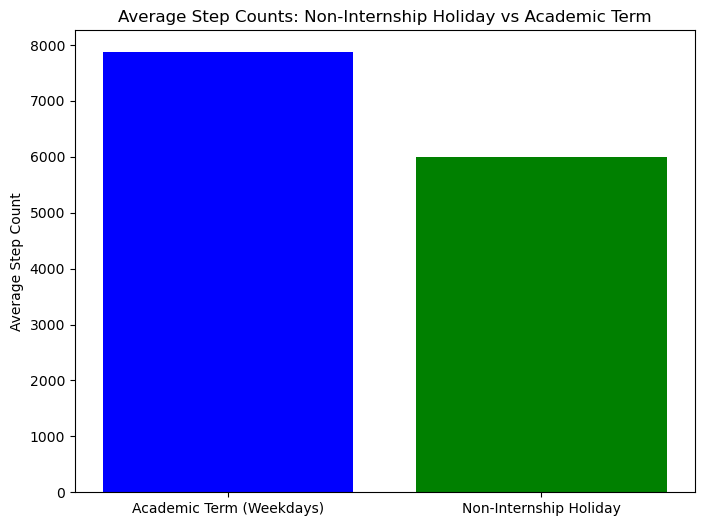

In [59]:
# Ortalama adım sayıları
academic_avg = academic_weekday['step_count'].mean()
non_internship_holiday_avg = non_internship_holiday['step_count'].mean()

# Bar grafiği
plt.figure(figsize=(8, 6))
plt.bar(['Academic Term (Weekdays)', 'Non-Internship Holiday'], 
        [academic_avg, non_internship_holiday_avg], color=['blue', 'green'])
plt.title('Average Step Counts: Non-Internship Holiday vs Academic Term')
plt.ylabel('Average Step Count')
plt.savefig('images/non_internship_holiday_vs_academic.png', dpi=300, bbox_inches='tight')
plt.show()


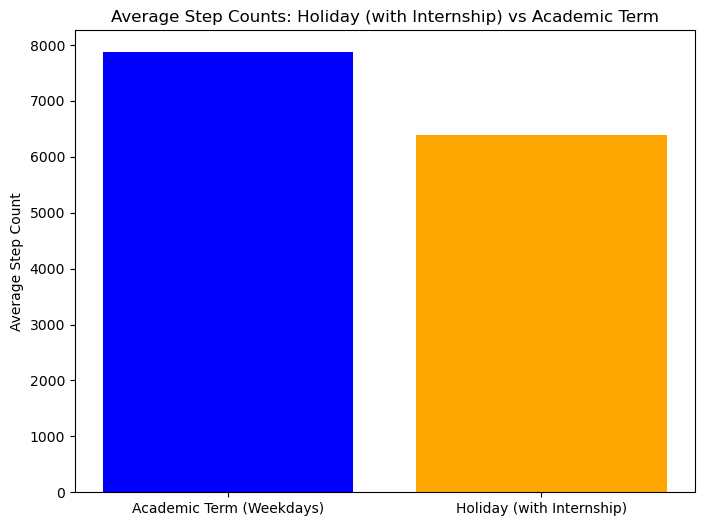

In [61]:
# Holiday (staj dahil) ortalaması
holiday_avg = holiday['step_count'].mean()

# Bar grafiği
plt.figure(figsize=(8, 6))
plt.bar(['Academic Term (Weekdays)', 'Holiday (with Internship)'], 
        [academic_avg, holiday_avg], color=['blue', 'orange'])
plt.title('Average Step Counts: Holiday (with Internship) vs Academic Term')
plt.ylabel('Average Step Count')
plt.savefig('images/holiday_with_internship_vs_academic.png', dpi=300, bbox_inches='tight')
plt.show()


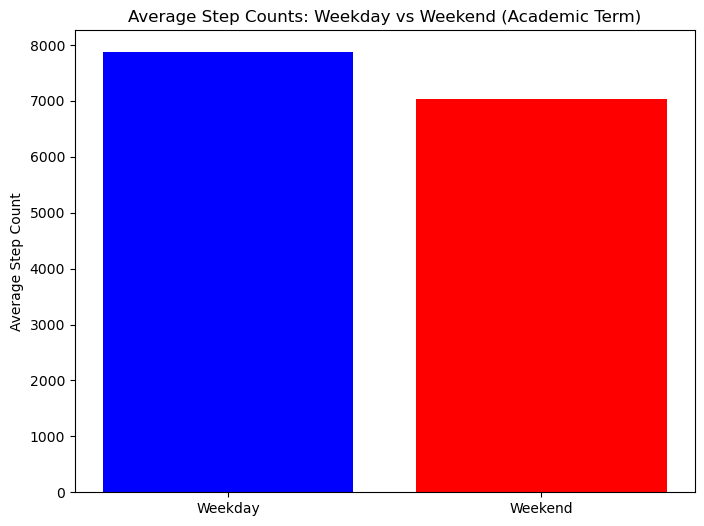

In [63]:
# Hafta içi ve hafta sonu ortalamaları
weekend_avg = step_df[
    (step_df['main_category'] == 'Academic Term') & 
    (step_df['week_type'] == 'Weekend')
]['step_count'].mean()

# Bar grafiği
plt.figure(figsize=(8, 6))
plt.bar(['Weekday', 'Weekend'], [academic_avg, weekend_avg], color=['blue', 'red'])
plt.title('Average Step Counts: Weekday vs Weekend (Academic Term)')
plt.ylabel('Average Step Count')
plt.savefig('images/weekday_vs_weekend_academic.png', dpi=300, bbox_inches='tight')
plt.show()


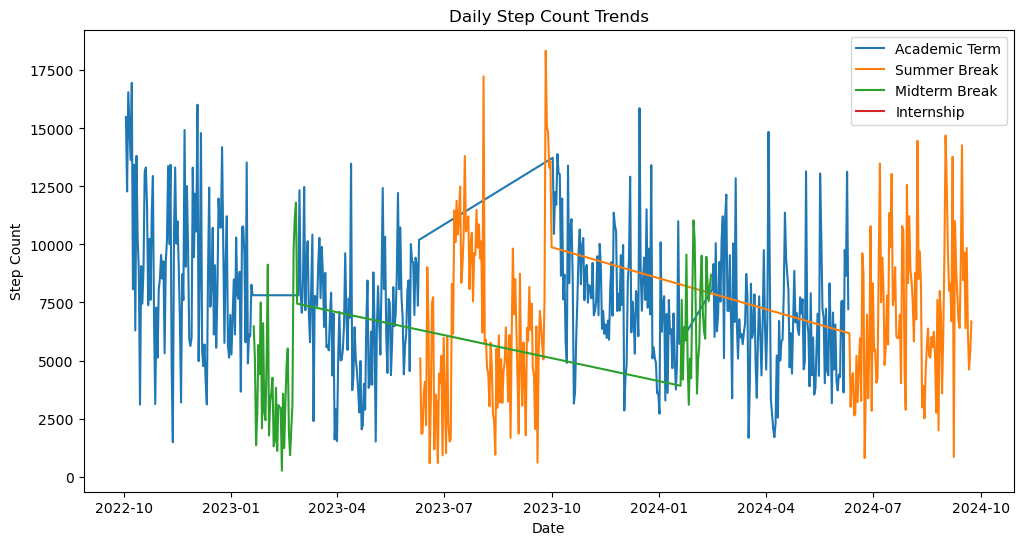

In [65]:
plt.figure(figsize=(12, 6))
for category in ['Academic Term', 'Summer Break', 'Midterm Break', 'Internship']:
    data = step_df[step_df['main_category'] == category]
    plt.plot(data['date'], data['step_count'], label=category)

plt.title('Daily Step Count Trends')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.legend()
plt.savefig('images/step_count_trends.png', dpi=300, bbox_inches='tight')
plt.show()


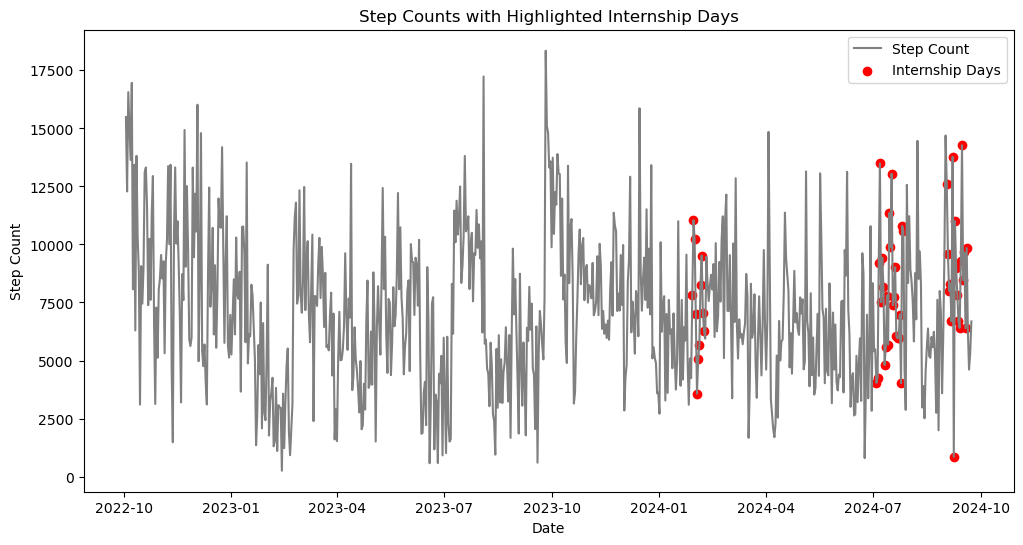

In [67]:
# Günlük adım sayıları grafiği
plt.figure(figsize=(12, 6))
plt.plot(step_df['date'], step_df['step_count'], label='Step Count', color='gray')

# Staj günlerini kırmızı nokta ile işaretle
plt.scatter(step_df[step_df['is_internship']]['date'], 
            step_df[step_df['is_internship']]['step_count'], 
            color='red', label='Internship Days')

plt.title('Step Counts with Highlighted Internship Days')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.legend()
plt.savefig('images/internship_highlighted.png', dpi=300, bbox_inches='tight')
plt.show()


In [69]:
# Haftaiçi Akademik Dönem verisi
academic_weekday = step_df[
    (step_df['main_category'] == 'Academic Term') & 
    (step_df['week_type'] == 'Weekday')
]

# Haftaiçi Stajsız Tatil verisi
non_internship_holiday_weekday = step_df[
    (step_df['main_category'].isin(['Summer Break', 'Midterm Break'])) & 
    (step_df['week_type'] == 'Weekday') & 
    (~step_df['is_internship'])
]

# Ortalama adım sayıları
academic_weekday_avg = academic_weekday['step_count'].mean()
non_internship_holiday_weekday_avg = non_internship_holiday_weekday['step_count'].mean()

# Sonuçları yazdır
print(f"Average Steps (Weekday Academic Term): {academic_weekday_avg:.2f}")
print(f"Average Steps (Weekday Non-Internship Holiday): {non_internship_holiday_weekday_avg:.2f}")
print(f"Ratio (Holiday to Academic): {non_internship_holiday_weekday_avg / academic_weekday_avg:.2f}")


Average Steps (Weekday Academic Term): 7868.89
Average Steps (Weekday Non-Internship Holiday): 5944.31
Ratio (Holiday to Academic): 0.76


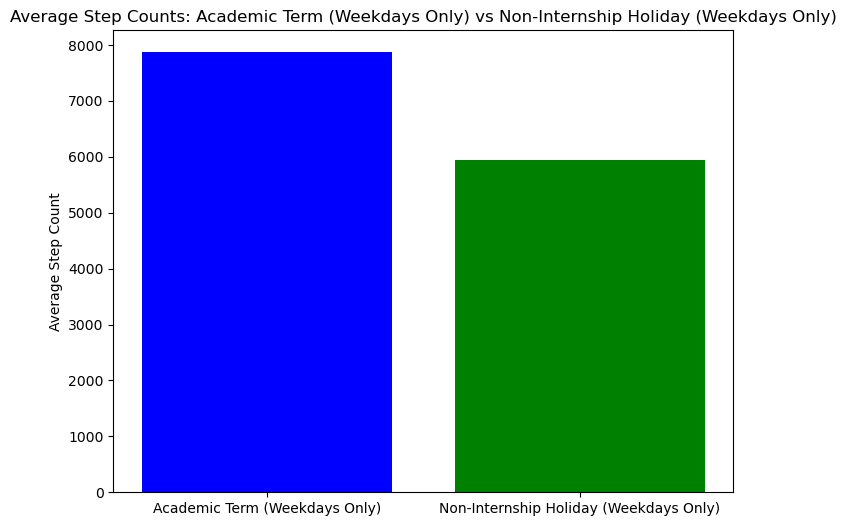

In [71]:
# Bar grafiği verisi
data = {
    'Academic Term (Weekdays Only)': academic_weekday_avg,
    'Non-Internship Holiday (Weekdays Only)': non_internship_holiday_weekday_avg
}

# Bar grafiği oluştur
plt.figure(figsize=(8, 6))
plt.bar(data.keys(), data.values(), color=['blue', 'green'])
plt.title('Average Step Counts: Academic Term (Weekdays Only) vs Non-Internship Holiday (Weekdays Only)')
plt.ylabel('Average Step Count')
plt.savefig('images/weekday_academic_vs_non_internship_holiday.png', dpi=300, bbox_inches='tight')
plt.show()


In [73]:
# Haftaiçi Akademik Dönem verisi
academic_weekday = step_df[
    (step_df['main_category'] == 'Academic Term') & 
    (step_df['week_type'] == 'Weekday')
]

# Okul zamanı hafta sonları
academic_weekend = step_df[
    (step_df['main_category'] == 'Academic Term') & 
    (step_df['week_type'] == 'Weekend')
]

# Stajsız tatil günleri
non_internship_holiday = step_df[
    (step_df['main_category'].isin(['Summer Break', 'Midterm Break'])) & 
    (~step_df['is_internship'])
]

# "Yattığınmzamanlar" = okul hafta sonları + stajsız tatil günleri
rest_time = pd.concat([academic_weekend, non_internship_holiday])

# Ortalama adım sayıları
academic_weekday_avg = academic_weekday['step_count'].mean()
rest_time_avg = rest_time['step_count'].mean()

# Sonuçları yazdır
print(f"Average Steps (Weekday Academic Term): {academic_weekday_avg:.2f}")
print(f"Average Steps (Rest Time - Weekends + Non-Internship Holiday): {rest_time_avg:.2f}")
print(f"Ratio (Rest Time to Academic Weekdays): {rest_time_avg / academic_weekday_avg:.2f}")


Average Steps (Weekday Academic Term): 7868.89
Average Steps (Rest Time - Weekends + Non-Internship Holiday): 6356.97
Ratio (Rest Time to Academic Weekdays): 0.81


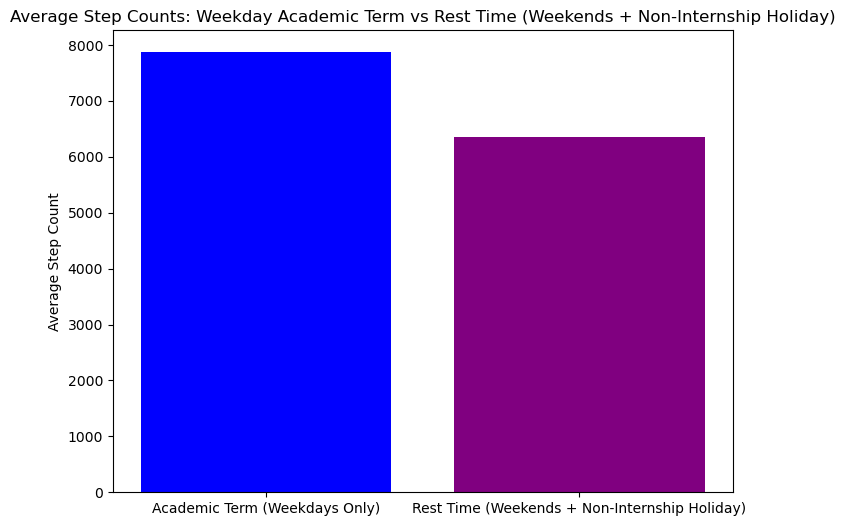

In [75]:
# Bar grafiği verisi
data = {
    'Academic Term (Weekdays Only)': academic_weekday_avg,
    'Rest Time (Weekends + Non-Internship Holiday)': rest_time_avg
}

# Bar grafiği oluştur
plt.figure(figsize=(8, 6))
plt.bar(data.keys(), data.values(), color=['blue', 'purple'])
plt.title('Average Step Counts: Weekday Academic Term vs Rest Time (Weekends + Non-Internship Holiday)')
plt.ylabel('Average Step Count')
plt.savefig('images/weekday_academic_vs_rest_time.png', dpi=300, bbox_inches='tight')
plt.show()


In [77]:
# Okul zamanı hafta sonları verisi
academic_weekend = step_df[
    (step_df['main_category'] == 'Academic Term') & 
    (step_df['week_type'] == 'Weekend')
]

# Stajsız tatil günleri (Holiday - Internship)
non_internship_holiday = step_df[
    (step_df['main_category'].isin(['Summer Break', 'Midterm Break'])) &
    (~step_df['is_internship'])
]

# Ortalama adım sayıları
academic_weekend_avg = academic_weekend['step_count'].mean()
non_internship_holiday_avg = non_internship_holiday['step_count'].mean()

# Sonuçları yazdır
print(f"Average Steps (Academic Term Weekends): {academic_weekend_avg:.2f}")
print(f"Average Steps (Non-Internship Holiday): {non_internship_holiday_avg:.2f}")
print(f"Ratio (Holiday to Academic Weekends): {non_internship_holiday_avg / academic_weekend_avg:.2f}")


Average Steps (Academic Term Weekends): 7034.99
Average Steps (Non-Internship Holiday): 5994.38
Ratio (Holiday to Academic Weekends): 0.85


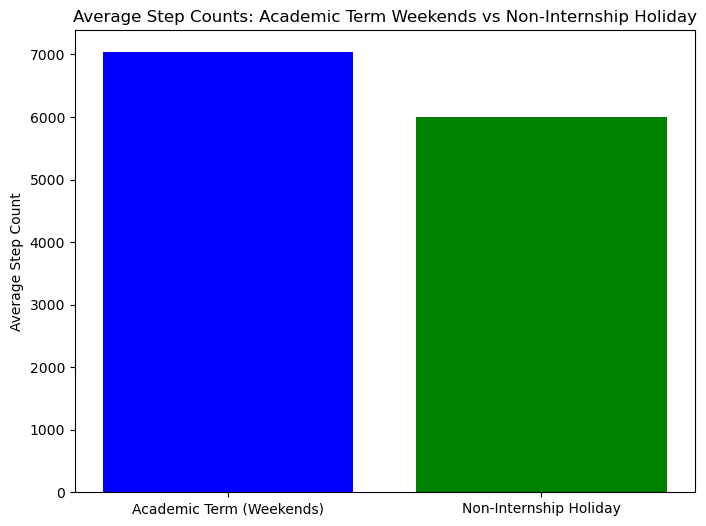

In [79]:
# Bar grafiği için veri hazırla
data = {
    'Academic Term (Weekends)': academic_weekend_avg,
    'Non-Internship Holiday': non_internship_holiday_avg
}

# Bar grafiği oluştur
plt.figure(figsize=(8, 6))
plt.bar(data.keys(), data.values(), color=['blue', 'green'])
plt.title('Average Step Counts: Academic Term Weekends vs Non-Internship Holiday')
plt.ylabel('Average Step Count')
plt.savefig('images/academic_weekend_vs_non_internship_holiday.png', dpi=300, bbox_inches='tight')
plt.show()


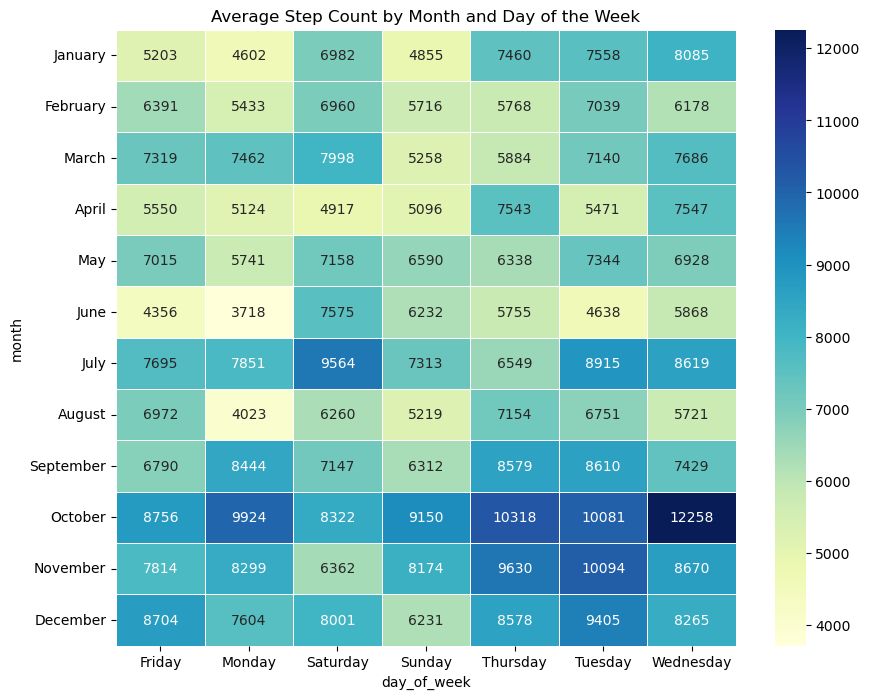

In [83]:
# Tarihleri haftanın gününe ve aya göre ayırma
step_df['day_of_week'] = pd.to_datetime(step_df['date']).dt.day_name()
step_df['month'] = pd.to_datetime(step_df['date']).dt.strftime('%B')

# Pivot tablo oluşturarak heatmap için veri hazırla
heatmap_data = step_df.pivot_table(
    values='step_count',
    index='month',
    columns='day_of_week',
    aggfunc='mean'
)

# Aylara göre sıralama
heatmap_data = heatmap_data.loc[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

# Heatmap oluştur
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)

plt.title('Average Step Count by Month and Day of the Week')
plt.savefig('images/heatmap_steps_month_weekday.png', dpi=300, bbox_inches='tight')
plt.show()



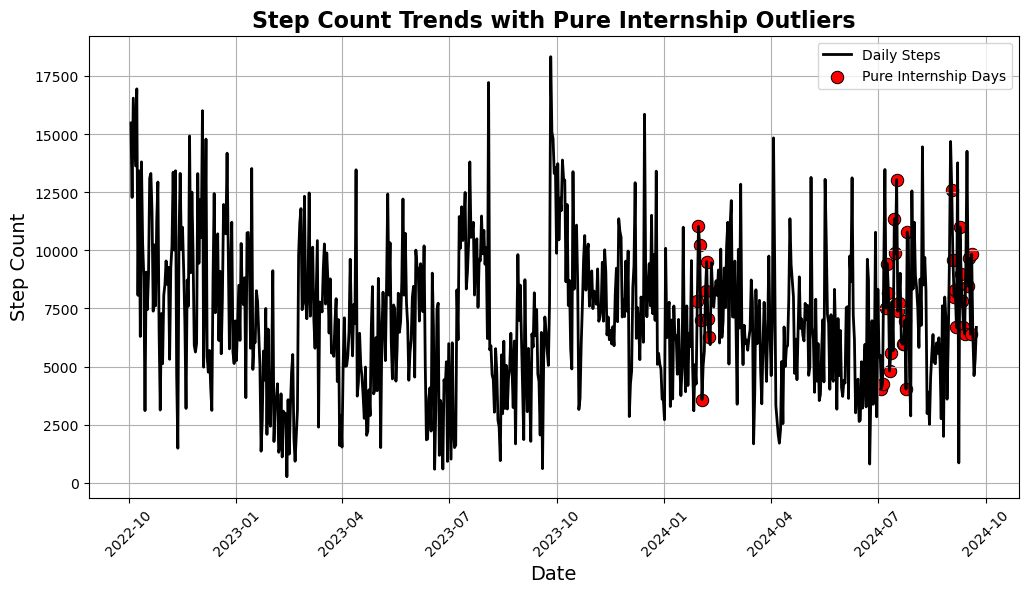

In [91]:
# Staj günleri içerisinden sadece hafta içi olanları al
pure_internship_days = step_df[
    (step_df['is_internship']) & (step_df['week_type'] == 'Weekday')
]

plt.figure(figsize=(12, 6))

# Çizgi Grafiği: Tüm veriyi göster
sns.lineplot(data=step_df, x='date', y='step_count', color='black', linewidth=2, label='Daily Steps')

# Pure Outlier Noktaları: Staj dönemindeki hafta içleri
sns.scatterplot(
    data=pure_internship_days,
    x='date',
    y='step_count',
    color='red',
    s=80,
    label='Pure Internship Days',
    edgecolor='black'
)

# Stil ve düzen
plt.title('Step Count Trends with Pure Internship Outliers', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Step Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Kaydetme
plt.savefig('images/pure_internship_outliers.png', dpi=300, bbox_inches='tight')
plt.show()
